# Previsões do IBC-Br

O Sistema de Expectativas do Mercado do Banco Central não fornece as expectativas do IBC-Br, mas apenas do PIB Trimestral. Para obter-se as previsões anuais do IBC-Br, será feito o seguinte:
- calcular a trajetória do IBC-Br fazendo-se uma previsão 12 meses utilizando-se o modelo ARIMA.
- calibrar a previsão com as expectativas ajustanto-a pelo PIB trimestral esperado pelo mercado obtido no Bacen.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import random
seed = 42
random.seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(15,8)})

## Função para ajuste 
Função para ajuste da previsão SARIMA pela previsão do PIB trimestral do BC. Esta função recebe como parâmetros a série prevista do IBC-Br que se quer ajustar, no formato Pandas Series, a série do IBC-Br real do ano anterior, também no formato Pandas Series e o vetor com as 4 previsões trimestrais do PIB do BC no shape (4,1).

In [2]:
def ajuste_bc(ibcbr_ant, ibcbr_pred, pib_var):
    # calcula a participação percentual de cada mês no IBC-Br total do trimestre
    part_pred_tri = ibcbr_pred.to_numpy().reshape(4,3)/np.sum(ibcbr_pred.to_numpy().reshape(4,3), 
                                                              axis=1).reshape(4,1)
    # calcula o IBC-Br trimestral baseado na previsão do BC
    ibcbr_new_tri = np.sum(ibcbr_ant.to_numpy().reshape(4,3)*pib_var, axis=1).reshape(4,1)
    # transforma o IBC-Br trimestral em mensal considerando a participação calculada
    ibcbr_new = part_pred_tri * ibcbr_new_tri 
    # transforma o IBC-Br ajustado em Pandas Series e retorna
    s_ibcbr_new = pd.Series(ibcbr_new.reshape(12,))
    s_ibcbr_new.index = ibcbr_pred.index
    return s_ibcbr_new

##  Carga dos Dados

In [3]:
df_main = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [4]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cria a série real do IBC-Br

In [5]:
datas = df_main['date']

In [6]:
ibcbr_ts = pd.Series(list(df_main['ibc_br']), index = datas)
ibcbr_ts

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2022-08-01    149.60
2022-09-01    144.44
2022-10-01    142.34
2022-11-01    140.80
2022-12-01    142.78
Length: 240, dtype: float64

## IBC-Br Previsto 2022

In [7]:
corte22 = 240-12*1
ibcbr22_train = ibcbr_ts[:corte22]
ibcbr22_test = ibcbr_ts[corte22:]
print(ibcbr22_train)
print(ibcbr22_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2021-08-01    141.97
2021-09-01    138.79
2021-10-01    138.02
2021-11-01    139.75
2021-12-01    141.61
Length: 228, dtype: float64
date
2022-01-01    131.55
2022-02-01    136.57
2022-03-01    149.16
2022-04-01    142.80
2022-05-01    142.75
2022-06-01    142.35
2022-07-01    149.50
2022-08-01    149.60
2022-09-01    144.44
2022-10-01    142.34
2022-11-01    140.80
2022-12-01    142.78
dtype: float64


In [8]:
mod_aa_aic22 = auto_arima(y=ibcbr22_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic22

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

In [9]:
mod_arima22 = ARIMA(endog=ibcbr22_train, order=(3, 1, 2), seasonal_order=(2, 0, 1, 12))
res_arima22 = mod_arima22.fit()
print(res_arima22.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  228
Model:             ARIMA(3, 1, 2)x(2, 0, [1], 12)   Log Likelihood                -546.343
Date:                            Thu, 27 Apr 2023   AIC                           1110.685
Time:                                    15:34:08   BIC                           1141.510
Sample:                                01-01-2003   HQIC                          1123.123
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3873      0.069    -20.182      0.000      -1.522      -1.253
ar.L2         -1.2541      0.080   

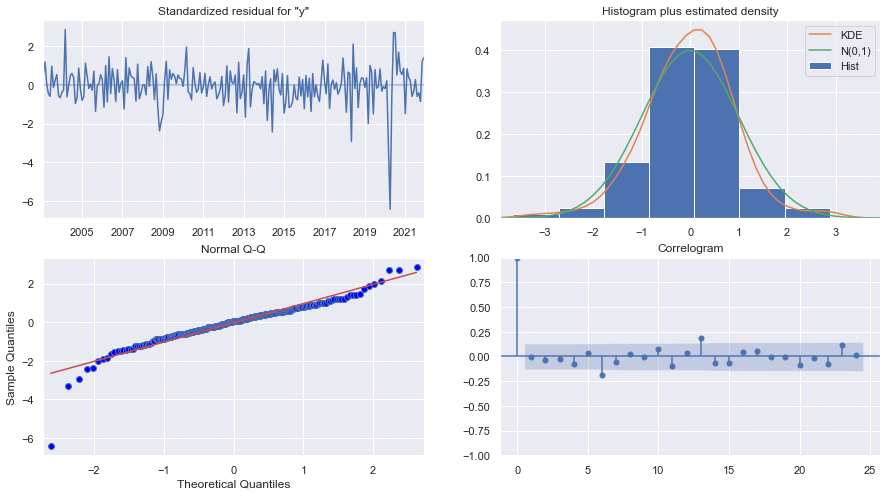

In [10]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima22.plot_diagnostics(lags=24)

### Previsão IBC-Br 2022

In [11]:
y22_pred = res_arima22.forecast(12)
y22_pred

2022-01-01    136.055194
2022-02-01    137.534213
2022-03-01    147.262263
2022-04-01    141.721412
2022-05-01    142.425843
2022-06-01    141.993417
2022-07-01    146.392591
2022-08-01    147.496898
2022-09-01    143.870096
2022-10-01    145.227265
2022-11-01    144.321991
2022-12-01    142.547495
Freq: MS, Name: predicted_mean, dtype: float64

In [12]:
mape22 = mean_absolute_percentage_error(ibcbr22_test, y22_pred)
mape22

0.012672909695255969

#### Ajuste pela Previsão de PIB do BC

In [13]:
pib22 = np.array([1.0031, 1.003, 1.004, 1.004]).reshape(4,1)

In [14]:
ibcbr22_train[-12:]

date
2021-01-01    131.12
2021-02-01    134.17
2021-03-01    144.72
2021-04-01    139.28
2021-05-01    137.69
2021-06-01    137.91
2021-07-01    143.07
2021-08-01    141.97
2021-09-01    138.79
2021-10-01    138.02
2021-11-01    139.75
2021-12-01    141.61
dtype: float64

In [15]:
y22_pred_aju = ajuste_bc(ibcbr22_train[-12:], y22_pred, pib22) 
y22_pred_aju

2022-01-01    132.961146
2022-02-01    134.406531
2022-03-01    143.913354
2022-04-01    138.390385
2022-05-01    139.078259
2022-06-01    138.655997
2022-07-01    142.301291
2022-08-01    143.374735
2022-09-01    139.849294
2022-10-01    141.516991
2022-11-01    140.634845
2022-12-01    138.905684
Freq: MS, dtype: float64

In [16]:
mape22_adj = mean_absolute_percentage_error(ibcbr22_test, y22_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape22, mape22_adj, mape22-mape22_adj))

 previsto: 0.012672909695255969
 ajustado: 0.02499430788465432
diferença: -0.01232139818939835


#### Persiste o dado em um arquivo CSV

In [17]:
pd.DataFrame({'ibcbr':y22_pred_aju}).to_excel('./dados/ibcbr_previsao_2022.xlsx', index_label='date')

## IBC-Br Previsto 2021

In [18]:
corte21 = 240-12*2
ibcbr21_train = ibcbr_ts[:corte21]
ibcbr21_test = ibcbr_ts[corte21:corte21+12]
print(ibcbr21_train)
print(ibcbr21_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2020-08-01    135.61
2020-09-01    137.09
2020-10-01    139.80
2020-11-01    138.14
2020-12-01    139.27
Length: 216, dtype: float64
date
2021-01-01    131.12
2021-02-01    134.17
2021-03-01    144.72
2021-04-01    139.28
2021-05-01    137.69
2021-06-01    137.91
2021-07-01    143.07
2021-08-01    141.97
2021-09-01    138.79
2021-10-01    138.02
2021-11-01    139.75
2021-12-01    141.61
dtype: float64


In [19]:
mod_aa_aic21 = auto_arima(y=ibcbr21_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic21

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [20]:
mod_arima21 = ARIMA(endog=ibcbr21_train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 12))
res_arima21 = mod_arima21.fit()
print(res_arima21.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  216
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -531.820
Date:                          Thu, 27 Apr 2023   AIC                           1075.639
Time:                                  15:34:30   BIC                           1095.863
Sample:                              01-01-2003   HQIC                          1083.811
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5549      0.162      3.425      0.001       0.237       0.872
ar.L2          0.1433      0.097      1.482      0.

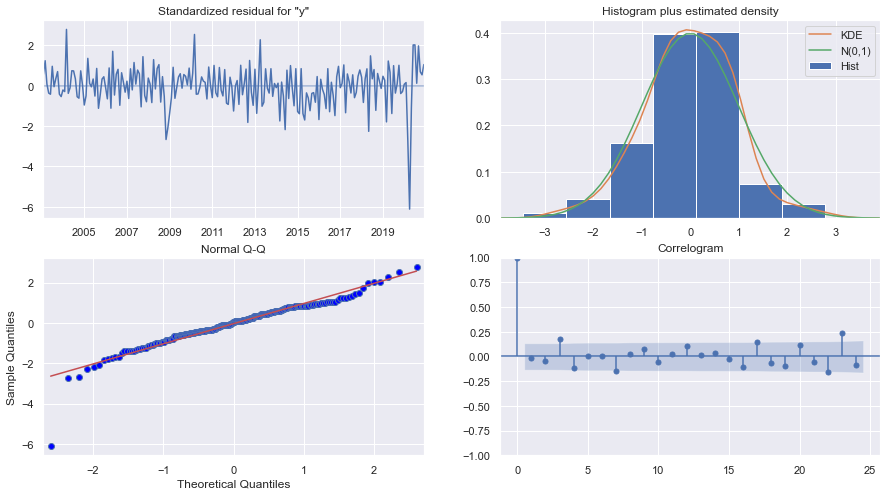

In [21]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima21.plot_diagnostics(lags=24)

### Previsão IBC-Br 2021

In [22]:
y21_pred = res_arima21.forecast(12)
y21_pred

2021-01-01    134.397981
2021-02-01    134.214571
2021-03-01    141.756926
2021-04-01    135.854214
2021-05-01    135.076205
2021-06-01    135.360872
2021-07-01    140.995128
2021-08-01    141.148683
2021-09-01    138.015806
2021-10-01    140.413035
2021-11-01    138.061209
2021-12-01    137.432713
Freq: MS, Name: predicted_mean, dtype: float64

In [23]:
mape21 = mean_absolute_percentage_error(ibcbr21_test, y21_pred)
mape21

0.01605476650455873

#### Ajuste pela Previsão de PIB do BC

In [24]:
pib21 = np.array([0.9943,1.102,1.0304,1.02]).reshape(4,1)

In [25]:
ibcbr21_train[-12:]

date
2020-01-01    133.92
2020-02-01    134.36
2020-03-01    136.03
2020-04-01    118.33
2020-05-01    119.45
2020-06-01    125.80
2020-07-01    135.81
2020-08-01    135.61
2020-09-01    137.09
2020-10-01    139.80
2020-11-01    138.14
2020-12-01    139.27
dtype: float64

In [26]:
y21_pred_aju = ajuste_bc(ibcbr21_train[-12:], y21_pred, pib21) 
y21_pred_aju

2021-01-01    131.658716
2021-02-01    131.479044
2021-03-01    138.867672
2021-04-01    133.972969
2021-05-01    133.205733
2021-06-01    133.486458
2021-07-01    141.253214
2021-08-01    141.407051
2021-09-01    138.268439
2021-10-01    143.670010
2021-11-01    141.263632
2021-12-01    140.620558
Freq: MS, dtype: float64

In [27]:
mape21_adj = mean_absolute_percentage_error(ibcbr21_test, y21_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape21, mape21_adj, mape21-mape21_adj))

 previsto: 0.01605476650455873
 ajustado: 0.020543885522546254
diferença: -0.004489119017987524


#### Persiste o dado em um arquivo CSV

In [28]:
pd.DataFrame({'ibcbr':y21_pred_aju}).to_excel('./dados/ibcbr_previsao_2021.xlsx', index_label='date')

## IBC-Br Previsto 2020

In [29]:
corte20 = 240-12*3
ibcbr20_train = ibcbr_ts[:corte20]
ibcbr20_test = ibcbr_ts[corte20:corte20+12]
print(ibcbr20_train)
print(ibcbr20_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2019-08-01    141.95
2019-09-01    138.33
2019-10-01    142.94
2019-11-01    138.88
2019-12-01    137.43
Length: 204, dtype: float64
date
2020-01-01    133.92
2020-02-01    134.36
2020-03-01    136.03
2020-04-01    118.33
2020-05-01    119.45
2020-06-01    125.80
2020-07-01    135.81
2020-08-01    135.61
2020-09-01    137.09
2020-10-01    139.80
2020-11-01    138.14
2020-12-01    139.27
dtype: float64


In [30]:
mod_aa_aic20 = auto_arima(y=ibcbr20_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic20

ARIMA(order=(4, 1, 4), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [31]:
mod_arima20 = ARIMA(endog=ibcbr20_train, order=(4, 1, 4), seasonal_order=(1, 0, 1, 12))
res_arima20 = mod_arima20.fit()
print(res_arima20.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             ARIMA(4, 1, 4)x(1, 0, [1], 12)   Log Likelihood                -449.750
Date:                            Thu, 27 Apr 2023   AIC                            921.500
Time:                                    15:35:37   BIC                            957.945
Sample:                                01-01-2003   HQIC                           936.244
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4677      0.218    -11.328      0.000      -2.895      -2.041
ar.L2         -2.8626      0.404   

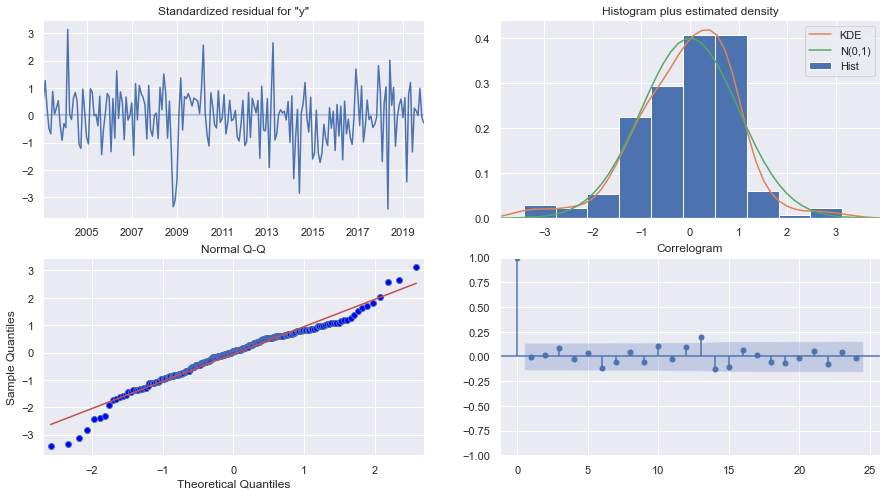

In [32]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima20.plot_diagnostics(lags=24)

### Previsão IBC-Br 2020

In [33]:
y20_pred = res_arima20.forecast(12)
y20_pred

2020-01-01    134.781986
2020-02-01    133.564211
2020-03-01    144.229949
2020-04-01    141.001398
2020-05-01    139.479710
2020-06-01    139.180183
2020-07-01    144.574755
2020-08-01    143.723809
2020-09-01    140.845501
2020-10-01    142.915654
2020-11-01    139.748432
2020-12-01    139.436212
Freq: MS, Name: predicted_mean, dtype: float64

In [34]:
mape20 = mean_absolute_percentage_error(ibcbr20_test, y20_pred)
mape20

0.06043039806752268

#### Ajuste pela Previsão de PIB do BC

In [35]:
pib20 = np.array([1.021,1.0223,1.0235,1.0234]).reshape(4,1)

In [36]:
ibcbr20_train[-12:]

date
2019-01-01    133.57
2019-02-01    133.92
2019-03-01    139.04
2019-04-01    139.70
2019-05-01    139.41
2019-06-01    135.12
2019-07-01    143.15
2019-08-01    141.95
2019-09-01    138.33
2019-10-01    142.94
2019-11-01    138.88
2019-12-01    137.43
dtype: float64

In [37]:
y20_pred_aju = ajuste_bc(ibcbr20_train[-12:], y20_pred, pib20) 
y20_pred_aju

2020-01-01    135.595750
2020-02-01    134.370623
2020-03-01    145.100757
2020-04-01    142.280183
2020-05-01    140.744695
2020-06-01    140.442451
2020-07-01    146.002007
2020-08-01    145.142661
2020-09-01    142.235937
2020-10-01    145.272238
2020-11-01    142.052790
2020-12-01    141.735422
Freq: MS, dtype: float64

In [38]:
mape20_adj = mean_absolute_percentage_error(ibcbr20_test, y20_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape20, mape20_adj, mape20-mape20_adj))

 previsto: 0.06043039806752268
 ajustado: 0.07036596835143978
diferença: -0.009935570283917103


#### Persiste o dado em um arquivo CSV

In [39]:
pd.DataFrame({'ibcbr':y20_pred_aju}).to_excel('./dados/ibcbr_previsao_2020.xlsx', index_label='date')

## IBC-Br Previsto 2019

In [40]:
corte19 = 240-12*4
ibcbr19_train = ibcbr_ts[:corte19]
ibcbr19_test = ibcbr_ts[corte19:corte19+12]
print(ibcbr19_train)
print(ibcbr19_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2018-08-01    143.43
2018-09-01    135.78
2018-10-01    139.86
2018-11-01    137.67
2018-12-01    136.34
Length: 192, dtype: float64
date
2019-01-01    133.57
2019-02-01    133.92
2019-03-01    139.04
2019-04-01    139.70
2019-05-01    139.41
2019-06-01    135.12
2019-07-01    143.15
2019-08-01    141.95
2019-09-01    138.33
2019-10-01    142.94
2019-11-01    138.88
2019-12-01    137.43
dtype: float64


In [41]:
mod_aa_aic19 = auto_arima(y=ibcbr19_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic19

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [42]:
mod_arima19 = ARIMA(endog=ibcbr19_train, order=(3, 1, 0), seasonal_order=(2, 0, 2, 12))
res_arima19 = mod_arima19.fit()
print(res_arima19.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  192
Model:             ARIMA(3, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -428.892
Date:                               Thu, 27 Apr 2023   AIC                            873.783
Time:                                       15:36:24   BIC                            899.802
Sample:                                   01-01-2003   HQIC                           884.322
                                        - 12-01-2018                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4830      0.065     -7.387      0.000      -0.611      -0.355
ar.L2      

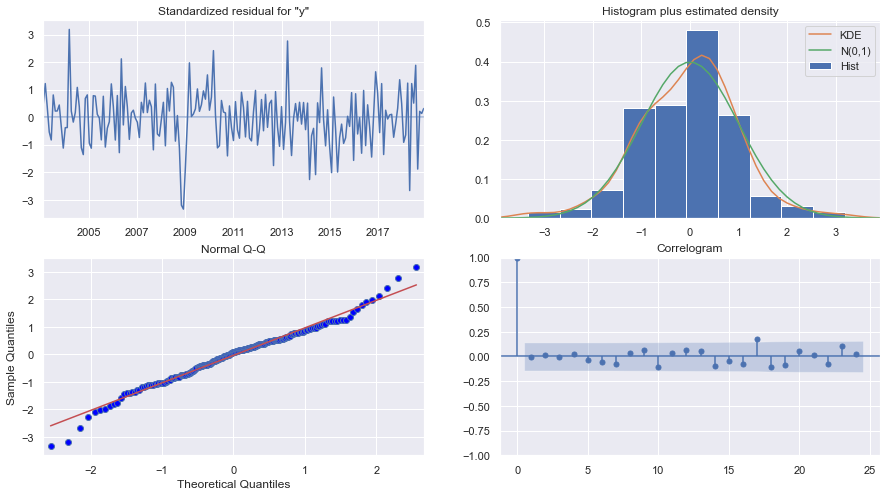

In [43]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima19.plot_diagnostics(lags=24)

### Previsão IBC-Br 2019

In [44]:
y19_pred = res_arima19.forecast(12)
y19_pred

2019-01-01    132.816560
2019-02-01    132.789078
2019-03-01    142.647849
2019-04-01    139.804973
2019-05-01    137.262963
2019-06-01    138.179760
2019-07-01    142.655081
2019-08-01    143.614976
2019-09-01    139.037434
2019-10-01    141.228788
2019-11-01    139.010882
2019-12-01    137.583181
Freq: MS, Name: predicted_mean, dtype: float64

In [45]:
mape19 = mean_absolute_percentage_error(ibcbr19_test, y19_pred)
mape19

0.009430018083227739

#### Ajuste pela Previsão de PIB do BC

In [46]:
pib19 = np.array([1.0215,1.025,1.027,1.028]).reshape(4,1)

In [47]:
ibcbr19_train[-12:]

date
2018-01-01    132.12
2018-02-01    129.95
2018-03-01    141.57
2018-04-01    139.08
2018-05-01    132.29
2018-06-01    136.96
2018-07-01    141.07
2018-08-01    143.43
2018-09-01    135.78
2018-10-01    139.86
2018-11-01    137.67
2018-12-01    136.34
dtype: float64

In [48]:
y19_pred_aju = ajuste_bc(ibcbr19_train[-12:], y19_pred, pib19) 
y19_pred_aju

2019-01-01    134.138947
2019-02-01    134.111192
2019-03-01    144.068122
2019-04-01    140.912832
2019-05-01    138.350678
2019-06-01    139.274740
2019-07-01    144.774935
2019-08-01    145.749094
2019-09-01    141.103530
2019-10-01    143.809675
2019-11-01    141.551238
2019-12-01    140.097447
Freq: MS, dtype: float64

In [49]:
mape19_adj = mean_absolute_percentage_error(ibcbr19_test, y19_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape19, mape19_adj, mape19-mape19_adj))

 previsto: 0.009430018083227739
 ajustado: 0.01598099682426319
diferença: -0.006550978741035451


#### Persiste o dado em um arquivo CSV

In [50]:
pd.DataFrame({'ibcbr':y19_pred_aju}).to_excel('./dados/ibcbr_previsao_2019.xlsx', index_label='date')

## IBC-Br Previsto 2018

In [51]:
corte18 = 240-12*5
ibcbr18_train = ibcbr_ts[:corte18]
ibcbr18_test = ibcbr_ts[corte18:corte18+12]
print(ibcbr18_train)
print(ibcbr18_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2017-08-01    140.15
2017-09-01    134.85
2017-10-01    136.06
2017-11-01    135.08
2017-12-01    135.77
Length: 180, dtype: float64
date
2018-01-01    132.12
2018-02-01    129.95
2018-03-01    141.57
2018-04-01    139.08
2018-05-01    132.29
2018-06-01    136.96
2018-07-01    141.07
2018-08-01    143.43
2018-09-01    135.78
2018-10-01    139.86
2018-11-01    137.67
2018-12-01    136.34
dtype: float64


In [52]:
mod_aa_aic18 = auto_arima(y=ibcbr18_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic18

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [53]:
mod_arima18 = ARIMA(endog=ibcbr18_train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
res_arima18 = mod_arima18.fit()
print(res_arima18.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             ARIMA(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -397.386
Date:                            Thu, 27 Apr 2023   AIC                            808.772
Time:                                    15:36:40   BIC                            831.084
Sample:                                01-01-2003   HQIC                           817.819
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1366      0.018    -62.027      0.000      -1.173      -1.101
ar.L2         -0.9910      0.015   

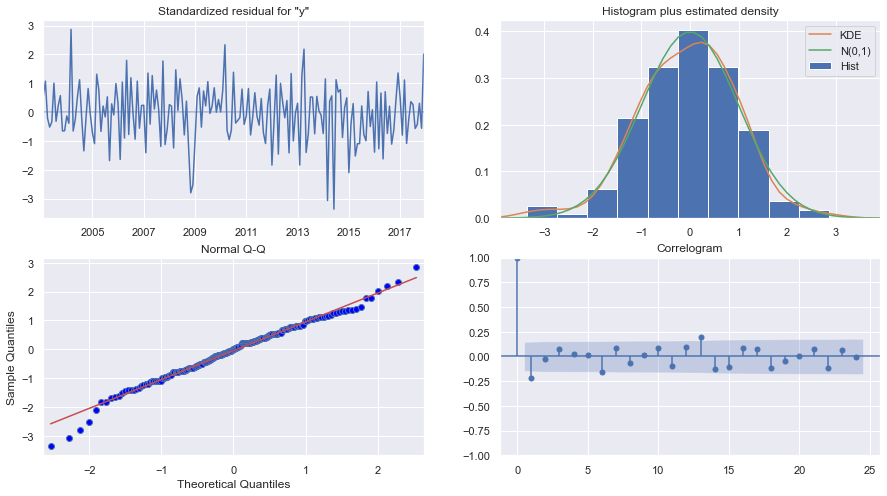

In [54]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima18.plot_diagnostics(lags=24)

### Previsão IBC-Br 2018

In [55]:
y18_pred = res_arima18.forecast(12)
y18_pred

2018-01-01    130.819299
2018-02-01    134.176129
2018-03-01    142.646899
2018-04-01    137.940042
2018-05-01    140.798165
2018-06-01    137.293333
2018-07-01    142.264872
2018-08-01    144.650258
2018-09-01    138.539639
2018-10-01    141.240594
2018-11-01    140.553371
2018-12-01    136.347692
Freq: MS, Name: predicted_mean, dtype: float64

In [56]:
mape18 = mean_absolute_percentage_error(ibcbr18_test, y18_pred)
mape18

0.016090952859758416

#### Ajuste pela Previsão de PIB do BC

In [57]:
pib18 = np.array([1.0209,1.025,1.029,1.033]).reshape(4,1)

In [58]:
ibcbr18_train[-12:]

date
2017-01-01    128.47
2017-02-01    129.39
2017-03-01    141.90
2017-04-01    133.75
2017-05-01    135.99
2017-06-01    134.89
2017-07-01    138.43
2017-08-01    140.15
2017-09-01    134.85
2017-10-01    136.06
2017-11-01    135.08
2017-12-01    135.77
dtype: float64

In [59]:
y18_pred_aju = ajuste_bc(ibcbr18_train[-12:], y18_pred, pib18) 
y18_pred_aju

2018-01-01    130.970982
2018-02-01    134.331705
2018-03-01    142.812296
2018-04-01    137.513724
2018-05-01    140.363013
2018-06-01    136.869013
2018-07-01    142.253068
2018-08-01    144.638257
2018-09-01    138.528145
2018-10-01    141.982489
2018-11-01    141.291656
2018-12-01    137.063885
Freq: MS, dtype: float64

In [60]:
mape18_adj = mean_absolute_percentage_error(ibcbr18_test, y18_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape18, mape18_adj, mape18-mape18_adj))

 previsto: 0.016090952859758416
 ajustado: 0.01733196320983917
diferença: -0.0012410103500807533


#### Persiste o dado em um arquivo CSV

In [61]:
pd.DataFrame({'ibcbr':y18_pred_aju}).to_excel('./dados/ibcbr_previsao_2018.xlsx', index_label='date')

## IBC-Br Previsto 2017

In [62]:
corte17 = 240-12*6
ibcbr17_train = ibcbr_ts[:corte17]
ibcbr17_test = ibcbr_ts[corte17:corte17+12]
print(ibcbr17_train)
print(ibcbr17_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2016-08-01    138.17
2016-09-01    133.88
2016-10-01    132.74
2016-11-01    132.37
2016-12-01    133.32
Length: 168, dtype: float64
date
2017-01-01    128.47
2017-02-01    129.39
2017-03-01    141.90
2017-04-01    133.75
2017-05-01    135.99
2017-06-01    134.89
2017-07-01    138.43
2017-08-01    140.15
2017-09-01    134.85
2017-10-01    136.06
2017-11-01    135.08
2017-12-01    135.77
dtype: float64


In [63]:
mod_aa_aic17 = auto_arima(y=ibcbr17_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic17

ARIMA(order=(4, 1, 5), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [64]:
mod_arima17 = ARIMA(endog=ibcbr17_train, order=(4, 1, 5), seasonal_order=(1, 0, 1, 12))
res_arima17 = mod_arima17.fit()
print(res_arima17.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             ARIMA(4, 1, 5)x(1, 0, [1], 12)   Log Likelihood                -365.627
Date:                            Thu, 27 Apr 2023   AIC                            755.254
Time:                                    15:38:00   BIC                            792.670
Sample:                                01-01-2003   HQIC                           770.441
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0742      0.233      0.318      0.750      -0.383       0.531
ar.L2         -0.4038      0.186   

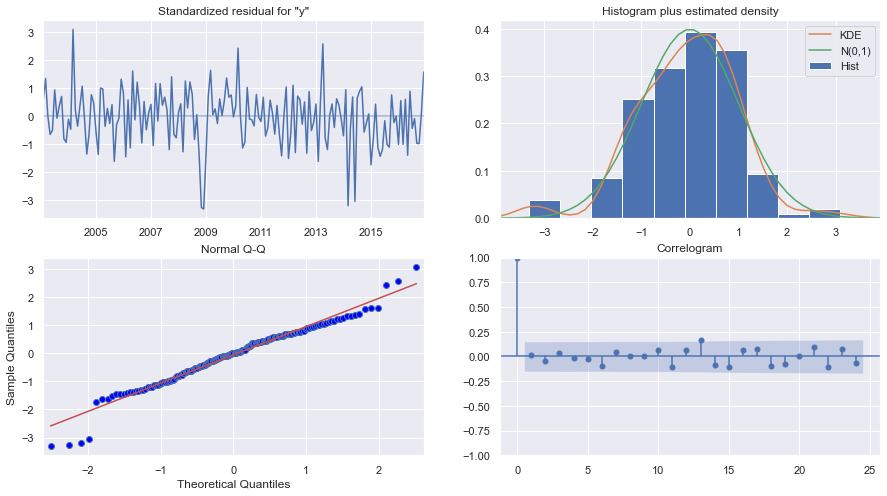

In [65]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima17.plot_diagnostics(lags=24)

### Previsão IBC-Br 2017

In [66]:
y17_pred = res_arima17.forecast(12)
y17_pred

2017-01-01    125.493873
2017-02-01    128.636471
2017-03-01    137.967795
2017-04-01    133.010804
2017-05-01    135.294877
2017-06-01    132.492544
2017-07-01    136.119550
2017-08-01    138.406912
2017-09-01    132.936604
2017-10-01    134.399459
2017-11-01    134.157004
2017-12-01    131.018252
Freq: MS, Name: predicted_mean, dtype: float64

In [67]:
mape17 = mean_absolute_percentage_error(ibcbr17_test, y17_pred)
mape17

0.01520542695477122

#### Ajuste pela Previsão de PIB do BC

In [68]:
pib17 = np.array([0.99,1.0,1.0109,1.0187]).reshape(4,1)

In [69]:
ibcbr17_train[-12:]

date
2016-01-01    128.26
2016-02-01    130.81
2016-03-01    140.29
2016-04-01    136.03
2016-05-01    133.56
2016-06-01    135.27
2016-07-01    136.70
2016-08-01    138.17
2016-09-01    133.88
2016-10-01    132.74
2016-11-01    132.37
2016-12-01    133.32
dtype: float64

In [70]:
y17_pred_aju = ajuste_bc(ibcbr17_train[-12:], y17_pred, pib17) 
y17_pred_aju

2017-01-01    126.539904
2017-02-01    129.708696
2017-03-01    139.117800
2017-04-01    134.358764
2017-05-01    136.665985
2017-06-01    133.835252
2017-07-01    138.037860
2017-08-01    140.357458
2017-09-01    134.810058
2017-10-01    136.520496
2017-11-01    136.274216
2017-12-01    133.085929
Freq: MS, dtype: float64

In [71]:
mape17_adj = mean_absolute_percentage_error(ibcbr17_test, y17_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape17, mape17_adj, mape17-mape17_adj))

 previsto: 0.01520542695477122
 ajustado: 0.007586583076898846
diferença: 0.007618843877872374


#### Persiste o dado em um arquivo CSV

In [72]:
pd.DataFrame({'ibcbr':y17_pred_aju}).to_excel('./dados/ibcbr_previsao_2017.xlsx', index_label='date')

## IBC-Br Previsto 2016

In [73]:
corte16 = 240-12*7
ibcbr16_train = ibcbr_ts[:corte16]
ibcbr16_test = ibcbr_ts[corte16:corte16+12]
print(ibcbr16_train)
print(ibcbr16_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2015-08-01    140.83
2015-09-01    138.07
2015-10-01    140.19
2015-11-01    135.94
2015-12-01    136.22
Length: 156, dtype: float64
date
2016-01-01    128.26
2016-02-01    130.81
2016-03-01    140.29
2016-04-01    136.03
2016-05-01    133.56
2016-06-01    135.27
2016-07-01    136.70
2016-08-01    138.17
2016-09-01    133.88
2016-10-01    132.74
2016-11-01    132.37
2016-12-01    133.32
dtype: float64


In [74]:
mod_aa_aic16 = auto_arima(y=ibcbr16_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic16

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [75]:
mod_arima16 = ARIMA(endog=ibcbr16_train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
res_arima16 = mod_arima16.fit()
print(res_arima16.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             ARIMA(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -350.708
Date:                            Thu, 27 Apr 2023   AIC                            715.416
Time:                                    15:38:25   BIC                            736.720
Sample:                                01-01-2003   HQIC                           724.069
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0707      0.091    -11.760      0.000      -1.249      -0.892
ar.L2         -0.7869      0.099   

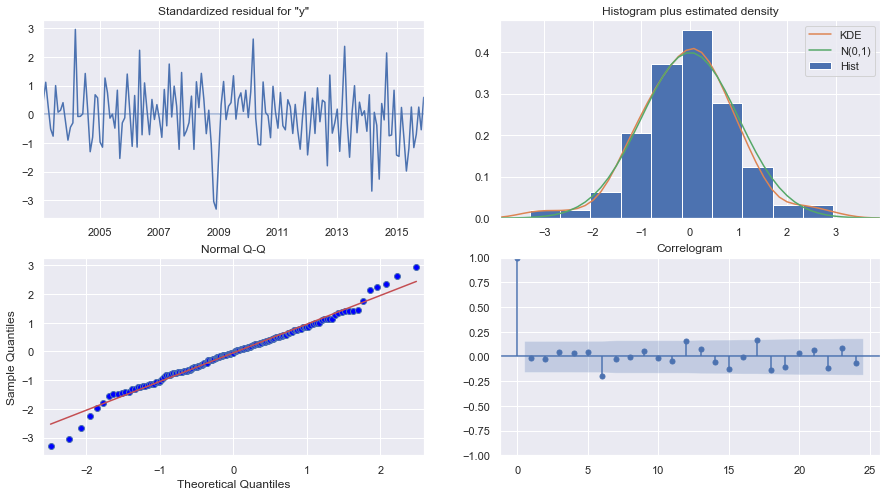

In [76]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima16.plot_diagnostics(lags=24)

### Previsão IBC-Br 2016

In [77]:
y16_pred = res_arima16.forecast(12)
y16_pred

2016-01-01    131.794252
2016-02-01    131.659926
2016-03-01    143.177525
2016-04-01    138.409639
2016-05-01    138.838597
2016-06-01    137.822608
2016-07-01    142.447628
2016-08-01    142.650677
2016-09-01    139.708544
2016-10-01    141.443424
2016-11-01    138.985922
2016-12-01    137.086310
Freq: MS, Name: predicted_mean, dtype: float64

In [78]:
mape16 = mean_absolute_percentage_error(ibcbr16_test, y16_pred)
mape16

0.03269412992174405

#### Ajuste pela Previsão de PIB do BC

In [79]:
pib16 = np.array([0.9540,0.9671,0.9796,0.9894]).reshape(4,1)

In [80]:
ibcbr16_train[-12:]

date
2015-01-01    138.73
2015-02-01    136.55
2015-03-01    149.50
2015-04-01    142.43
2015-05-01    139.81
2015-06-01    138.53
2015-07-01    143.15
2015-08-01    140.83
2015-09-01    138.07
2015-10-01    140.19
2015-11-01    135.94
2015-12-01    136.22
dtype: float64

In [81]:
y16_pred_aju = ajuste_bc(ibcbr16_train[-12:], y16_pred, pib16) 
y16_pred_aju

2016-01-01    131.343223
2016-02-01    131.209357
2016-03-01    142.687540
2016-04-01    135.693880
2016-05-01    136.114420
2016-06-01    135.118367
2016-07-01    138.636119
2016-08-01    138.833735
2016-09-01    135.970326
2016-10-01    138.212684
2016-11-01    135.811314
2016-12-01    133.955092
Freq: MS, dtype: float64

In [82]:
mape16_adj = mean_absolute_percentage_error(ibcbr16_test, y16_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape16, mape16_adj, mape16-mape16_adj))

 previsto: 0.03269412992174405
 ajustado: 0.014455802588385733
diferença: 0.01823832733335832


#### Persiste o dado em um arquivo CSV

In [83]:
pd.DataFrame({'ibcbr':y16_pred_aju}).to_excel('./dados/ibcbr_previsao_2016.xlsx', index_label='date')

## IBC-Br Previsto 2015

In [84]:
corte15 = 240-12*8
ibcbr15_train = ibcbr_ts[:corte15]
ibcbr15_test = ibcbr_ts[corte15:corte15+12]
print(ibcbr15_train)
print(ibcbr15_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2014-08-01    148.27
2014-09-01    148.12
2014-10-01    149.70
2014-11-01    144.92
2014-12-01    145.48
Length: 144, dtype: float64
date
2015-01-01    138.73
2015-02-01    136.55
2015-03-01    149.50
2015-04-01    142.43
2015-05-01    139.81
2015-06-01    138.53
2015-07-01    143.15
2015-08-01    140.83
2015-09-01    138.07
2015-10-01    140.19
2015-11-01    135.94
2015-12-01    136.22
dtype: float64


In [85]:
mod_aa_aic15 = auto_arima(y=ibcbr15_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic15

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [86]:
mod_arima15 = ARIMA(endog=ibcbr15_train, order=(2, 1, 3), seasonal_order=(2, 0, 0, 12))
res_arima15 = mod_arima15.fit()
print(res_arima15.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  144
Model:             ARIMA(2, 1, 3)x(2, 0, [], 12)   Log Likelihood                -327.149
Date:                           Thu, 27 Apr 2023   AIC                            670.298
Time:                                   15:38:54   BIC                            694.001
Sample:                               01-01-2003   HQIC                           679.930
                                    - 12-01-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1326      0.024    -48.036      0.000      -1.179      -1.086
ar.L2         -0.9786      0.026    -37.723

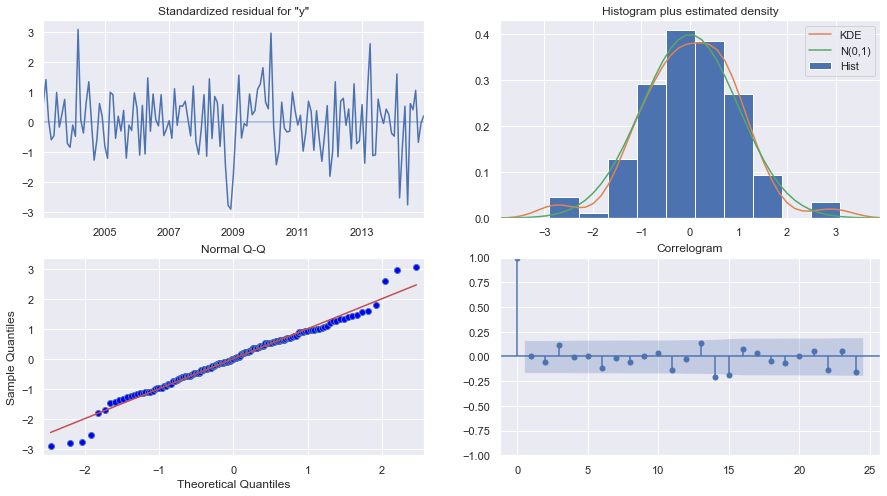

In [87]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima15.plot_diagnostics(lags=24)

### Previsão IBC-Br 2015

In [88]:
y15_pred = res_arima15.forecast(12)
y15_pred

2015-01-01    142.236035
2015-02-01    140.695468
2015-03-01    149.872692
2015-04-01    147.864867
2015-05-01    146.319572
2015-06-01    144.315981
2015-07-01    149.496232
2015-08-01    148.728712
2015-09-01    149.072976
2015-10-01    149.107981
2015-11-01    145.953007
2015-12-01    146.968357
Freq: MS, Name: predicted_mean, dtype: float64

In [89]:
mape15 = mean_absolute_percentage_error(ibcbr15_test, y15_pred)
mape15

0.048407962239084334

#### Ajuste pela Previsão de PIB do BC

In [90]:
pib15 = np.array([1.0,1.005,1.0058,1.0065]).reshape(4,1)

In [91]:
ibcbr15_train[-12:]

date
2014-01-01    142.72
2014-02-01    143.53
2014-03-01    149.03
2014-04-01    147.69
2014-05-01    147.14
2014-06-01    140.88
2014-07-01    149.85
2014-08-01    148.27
2014-09-01    148.12
2014-10-01    149.70
2014-11-01    144.92
2014-12-01    145.48
dtype: float64

In [92]:
y15_pred_aju = ajuste_bc(ibcbr15_train[-12:], y15_pred, pib15) 
y15_pred_aju

2015-01-01    143.049679
2015-02-01    141.500300
2015-03-01    150.730021
2015-04-01    147.658540
2015-05-01    146.115402
2015-06-01    144.114607
2015-07-01    150.007680
2015-08-01    149.237535
2015-09-01    149.582977
2015-10-01    149.422134
2015-11-01    146.260514
2015-12-01    147.278002
Freq: MS, dtype: float64

In [93]:
mape15_adj = mean_absolute_percentage_error(ibcbr15_test, y15_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape15, mape15_adj, mape15-mape15_adj))

 previsto: 0.048407962239084334
 ajustado: 0.05097352601059033
diferença: -0.002565563771505998


#### Persiste o dado em um arquivo CSV

In [94]:
pd.DataFrame({'ibcbr':y15_pred_aju}).to_excel('./dados/ibcbr_previsao_2015.xlsx', index_label='date')

## IBC-Br Previsto 2014

In [95]:
corte14 = 240-12*9
ibcbr14_train = ibcbr_ts[:corte14]
ibcbr14_test = ibcbr_ts[corte14:corte14+12]
print(ibcbr14_train)
print(ibcbr14_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2013-08-01    151.81
2013-09-01    147.27
2013-10-01    151.90
2013-11-01    147.79
2013-12-01    145.77
Length: 132, dtype: float64
date
2014-01-01    142.72
2014-02-01    143.53
2014-03-01    149.03
2014-04-01    147.69
2014-05-01    147.14
2014-06-01    140.88
2014-07-01    149.85
2014-08-01    148.27
2014-09-01    148.12
2014-10-01    149.70
2014-11-01    144.92
2014-12-01    145.48
dtype: float64


In [96]:
mod_aa_aic14 = auto_arima(y=ibcbr14_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic14

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [97]:
mod_arima14 = ARIMA(endog=ibcbr14_train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
res_arima14 = mod_arima14.fit()
print(res_arima14.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             ARIMA(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -288.032
Date:                            Thu, 27 Apr 2023   AIC                            590.064
Time:                                    15:39:09   BIC                            610.191
Sample:                                01-01-2003   HQIC                           598.242
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1613      0.019    -61.574      0.000      -1.198      -1.124
ar.L2         -0.9878      0.017   

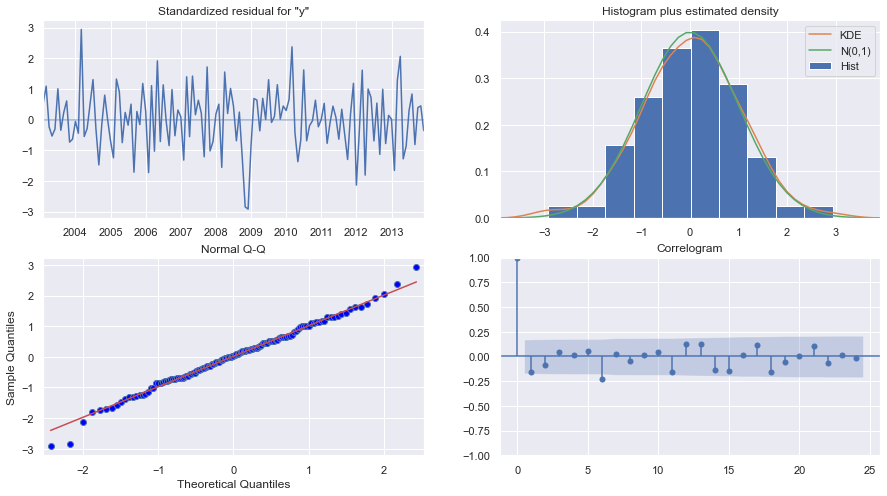

In [98]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima14.plot_diagnostics(lags=24)

### Previsão IBC-Br 2014

In [99]:
y14_pred = res_arima14.forecast(12)
y14_pred

2014-01-01    144.160580
2014-02-01    141.757219
2014-03-01    154.785556
2014-04-01    151.610424
2014-05-01    150.090378
2014-06-01    151.699629
2014-07-01    156.248744
2014-08-01    154.861148
2014-09-01    153.683593
2014-10-01    154.919339
2014-11-01    151.336341
2014-12-01    151.290848
Freq: MS, Name: predicted_mean, dtype: float64

In [100]:
mape14 = mean_absolute_percentage_error(ibcbr14_test, y14_pred)
mape14

0.035688413529156505

#### Ajuste pela Previsão de PIB do BC

In [101]:
pib14 = np.array([1.022,1.0158,1.0204,1.0221]).reshape(4,1)

In [102]:
ibcbr14_train[-12:]

date
2013-01-01    139.32
2013-02-01    136.14
2013-03-01    148.01
2013-04-01    149.79
2013-05-01    147.03
2013-06-01    144.87
2013-07-01    152.13
2013-08-01    151.81
2013-09-01    147.27
2013-10-01    151.90
2013-11-01    147.79
2013-12-01    145.77
dtype: float64

In [103]:
y14_pred_aju = ajuste_bc(ibcbr14_train[-12:], y14_pred, pib14) 
y14_pred_aju

2014-01-01    141.570807
2014-02-01    139.210622
2014-03-01    152.004911
2014-04-01    150.028204
2014-05-01    148.524021
2014-06-01    150.116477
2014-07-01    154.776731
2014-08-01    153.402207
2014-09-01    152.235746
2014-10-01    154.160274
2014-11-01    150.594831
2014-12-01    150.549561
Freq: MS, dtype: float64

In [104]:
mape14_adj = mean_absolute_percentage_error(ibcbr14_test, y14_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape14, mape14_adj, mape14-mape14_adj))

 previsto: 0.035688413529156505
 ajustado: 0.028998918519293218
diferença: 0.006689495009863287


#### Persiste o dado em um arquivo CSV

In [105]:
pd.DataFrame({'ibcbr':y14_pred_aju}).to_excel('./dados/ibcbr_previsao_2014.xlsx', index_label='date')

## IBC-Br Previsto 2013

In [106]:
corte13 = 240-12*10
ibcbr13_train = ibcbr_ts[:corte13]
ibcbr13_test = ibcbr_ts[corte13:corte13+12]
print(ibcbr13_train)
print(ibcbr13_test)

date
2003-01-01     96.15
2003-02-01     98.67
2003-03-01    103.41
2003-04-01    102.19
2003-05-01    100.30
               ...  
2012-08-01    149.91
2012-09-01    141.60
2012-10-01    147.71
2012-11-01    144.15
2012-12-01    139.52
Length: 120, dtype: float64
date
2013-01-01    139.32
2013-02-01    136.14
2013-03-01    148.01
2013-04-01    149.79
2013-05-01    147.03
2013-06-01    144.87
2013-07-01    152.13
2013-08-01    151.81
2013-09-01    147.27
2013-10-01    151.90
2013-11-01    147.79
2013-12-01    145.77
dtype: float64


In [107]:
mod_aa_aic13 = auto_arima(y=ibcbr13_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic')
mod_aa_aic13

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [108]:
mod_arima13 = ARIMA(endog=ibcbr13_train, order=(1, 1, 3), seasonal_order=(2, 0, 2, 12))
res_arima13 = mod_arima13.fit()
print(res_arima13.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  120
Model:             ARIMA(1, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood                -268.177
Date:                               Thu, 27 Apr 2023   AIC                            554.355
Time:                                       15:39:40   BIC                            579.367
Sample:                                   01-01-2003   HQIC                           564.511
                                        - 12-01-2012                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7053      0.175     -4.035      0.000      -1.048      -0.363
ma.L1      

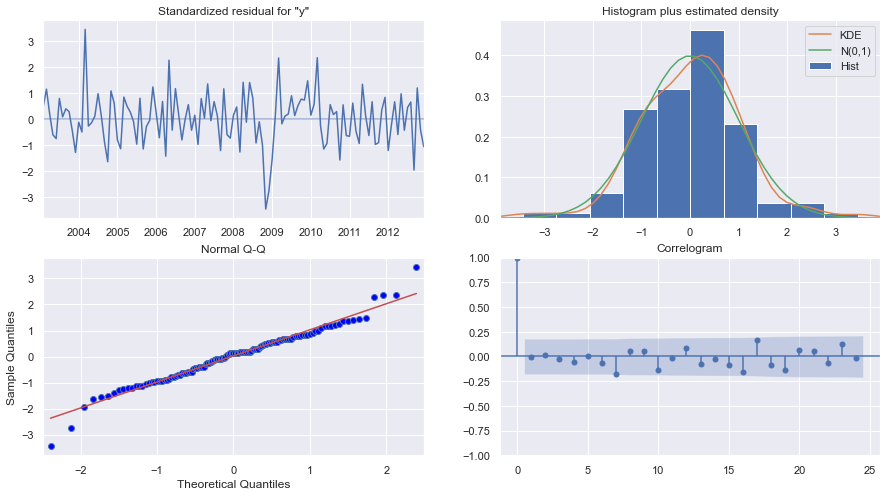

In [109]:
sns.set(rc={'figure.figsize':(15,8)})
ax = res_arima13.plot_diagnostics(lags=24)

### Previsão IBC-Br 2013

In [110]:
y13_pred = res_arima13.forecast(12)
y13_pred

2013-01-01    137.944990
2013-02-01    137.716394
2013-03-01    148.943046
2013-04-01    144.113931
2013-05-01    145.802515
2013-06-01    144.793612
2013-07-01    149.841149
2013-08-01    150.303930
2013-09-01    146.225448
2013-10-01    149.203406
2013-11-01    146.692188
2013-12-01    143.154145
Freq: MS, Name: predicted_mean, dtype: float64

In [111]:
mape13 = mean_absolute_percentage_error(ibcbr13_test, y13_pred)
mape13

0.012475541685431015

#### Ajuste pela Previsão de PIB do BC

In [112]:
pib13 = np.array([1.027,1.032,1.035,1.035]).reshape(4,1)

In [113]:
ibcbr13_train[-12:]

date
2012-01-01    133.34
2012-02-01    135.35
2012-03-01    146.35
2012-04-01    139.85
2012-05-01    144.56
2012-06-01    142.28
2012-07-01    147.46
2012-08-01    149.91
2012-09-01    141.60
2012-10-01    147.71
2012-11-01    144.15
2012-12-01    139.52
dtype: float64

In [114]:
y13_pred_aju = ajuste_bc(ibcbr13_train[-12:], y13_pred, pib13) 
y13_pred_aju

2013-01-01    138.478327
2013-02-01    138.248848
2013-03-01    149.518905
2013-04-01    145.981707
2013-05-01    147.692176
2013-06-01    146.670197
2013-07-01    152.514373
2013-08-01    152.985410
2013-09-01    148.834167
2013-10-01    151.727873
2013-11-01    149.174166
2013-12-01    145.576261
Freq: MS, dtype: float64

In [115]:
mape13_adj = mean_absolute_percentage_error(ibcbr13_test, y13_pred_aju)
print(' previsto: {}\n ajustado: {}\ndiferença: {}'.
      format(mape13, mape13_adj, mape13-mape13_adj))

 previsto: 0.012475541685431015
 ajustado: 0.008899892622358092
diferença: 0.003575649063072924


#### Persiste o dado em um arquivo CSV

In [116]:
pd.DataFrame({'ibcbr':y13_pred_aju}).to_excel('./dados/ibcbr_previsao_2013.xlsx', index_label='date')